train label: (6162, 1)
train feature: (6162, 2048)
test feature: (3704, 2048)
(250, 2048) (250, 300)
1 th classifier is training
2 th classifier is training
3 th classifier is training
4 th classifier is training
5 th classifier is training
6 th classifier is training
7 th classifier is training
8 th classifier is training
9 th classifier is training
10 th classifier is training
11 th classifier is training
12 th classifier is training
13 th classifier is training
14 th classifier is training
15 th classifier is training
16 th classifier is training
17 th classifier is training
18 th classifier is training
19 th classifier is training
20 th classifier is training
21 th classifier is training
22 th classifier is training
23 th classifier is training
24 th classifier is training
25 th classifier is training
26 th classifier is training
27 th classifier is training
28 th classifier is training
29 th classifier is training
30 th classifier is training
31 th classifier is training
32 th cla

275 th classifier is training
276 th classifier is training
277 th classifier is training
278 th classifier is training
279 th classifier is training
280 th classifier is training
281 th classifier is training
282 th classifier is training
283 th classifier is training
284 th classifier is training
285 th classifier is training
286 th classifier is training
287 th classifier is training
288 th classifier is training
289 th classifier is training
290 th classifier is training
291 th classifier is training
292 th classifier is training
293 th classifier is training
294 th classifier is training
295 th classifier is training
296 th classifier is training
297 th classifier is training
298 th classifier is training
299 th classifier is training
300 th classifier is training
(3704, 300)
994
Acc: 0.2683585313174946
oula dist 0.2683585313174946
cosine dist 0.2683585313174946


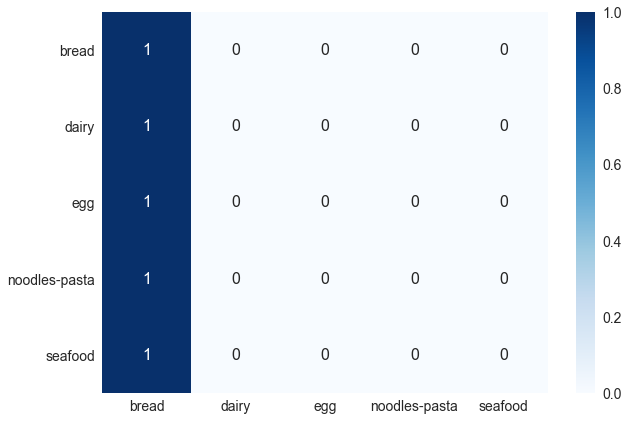

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso,SGDRegressor,PassiveAggressiveRegressor,ElasticNet,LinearRegression
import heapq
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

path = 'new_split/'

classname = pd.read_csv(path+'classes.txt',header=None,sep = '\t')
dic_class2name = {classname.index[i]:classname.loc[i][1] for i in range(classname.shape[0])}
dic_name2class = {classname.loc[i][1]:classname.index[i] for i in range(classname.shape[0])}

def make_test_attributetable():
    attribut_bmatrix = np.loadtxt(path+'food_label_vector.txt')
    #attribut_bmatrix = np.loadtxt(path+'label-vector-normed.txt')
    attribut_bmatrix = pd.DataFrame(attribut_bmatrix)
    test_classes = pd.read_csv(path+'testclasses.txt',header=None)
    test_classes_flag = []
    for item in test_classes.iloc[:,0].values.tolist():
        test_classes_flag.append(dic_name2class[item])
    return attribut_bmatrix.iloc[test_classes_flag,:]

def make_train_attributetable():
    attribut_bmatrix = np.loadtxt(path+'food_label_vector.txt')
    #attribut_bmatrix = np.loadtxt(path+'label-vector-normed.txt')
    attribut_bmatrix = pd.DataFrame(attribut_bmatrix)
    train_classes = pd.read_csv(path+'trainclasses.txt',header=None)
    train_classes_flag = []
    for item in train_classes.iloc[:,0].values.tolist():
        train_classes_flag.append(dic_name2class[item])
    return attribut_bmatrix.iloc[train_classes_flag,:]

def construct_Y(label_onehot):
    for i in range(label_onehot.shape[0]):
        for j in range(label_onehot.shape[1]):
            if label_onehot[i][j] == 0:
                label_onehot[i][j] = -1
    return np.mat(label_onehot)

def generate_data(data_mean,data_std,attribute_table,num):
    class_num = data_mean.shape[0]
    feature_num = data_mean.shape[1]
    data_list = []
    label_list = []
    for i in range(class_num):
        data = []
        for j in range(feature_num):
            data.append(list(np.random.normal(data_mean[i,j],np.abs(data_std[i,j]),num)))
        data = np.row_stack(data).T
        data_list.append(data)   
        label_list+=[test_attributetable.iloc[i,:].values]*num
    return np.row_stack(data_list),np.row_stack(label_list)

def cosinedist(gt, pre, top):
    dist_list = []
    labels = []
    for i in range(gt.values.shape[0]):
        dist = 1 - np.dot(gt.values[i],pre.transpose())/(np.linalg.norm(gt.values[i])*np.linalg.norm(pre))
        dist_list.append(dist)
    result = map(dist_list.index, heapq.nsmallest(top, dist_list))
    result = list(result)
    for loc in result:
        labels.append(gt.index[loc])
    
    #print("Result:", result)
    return labels


trainlabel = np.load(path+'Food11_trainlabel.npy')
print("train label:",trainlabel.shape)
#train_attributelabel = np.load(path+'AWA2_train_Label_attributelabel.npy')

testlabel = np.load(path+'Food11_testlabel.npy')
#test_attributelabel = np.load(path+'AWA2_test_Label_attributelabel.npy')

enc1 = OneHotEncoder()
enc1.fit(np.mat(trainlabel).T)
trainlabel_onehot = enc1.transform(np.mat(trainlabel).T).toarray()

enc2 = OneHotEncoder()
enc2.fit(np.mat(testlabel).T)
testlabel_onehot = enc2.transform(np.mat(testlabel).T).toarray()

trainfeatures = np.load(path+'resnet101_trainfeatures.npy')
print("train feature:", trainfeatures.shape)
testfeatures = np.load(path+'resnet101_testfeatures.npy')
print("test feature:", testfeatures.shape)
#print(trainfeatures.shape,trainlabel.shape,train_attributelabel.shape,trainlabel_onehot.shape)
#print(testfeatures.shape,testlabel.shape,test_attributelabel.shape,testlabel_onehot.shape)


train_attributetable = make_train_attributetable()
test_attributetable = make_test_attributetable()



trainfeatures_tabel = pd.DataFrame(trainfeatures)
trainfeatures_tabel['label'] = trainlabel

trainfeature_mean = np.mat(trainfeatures_tabel.groupby('label').mean().values).T
trainfeature_std = np.mat(trainfeatures_tabel.groupby('label').std().values).T


clf = Lasso(alpha=0.01)
clf.fit(np.mat(train_attributetable.values).T,np.mat(test_attributetable.values).T)
W = clf.coef_.T


virtual_testfeature_mean = (trainfeature_mean*W).T
virtual_testfeature_std = np.ones(virtual_testfeature_mean.shape)*0.3

virtual_testfeature,virtual_test_attributelabel = generate_data(virtual_testfeature_mean,virtual_testfeature_std,test_attributetable,50)
print(virtual_testfeature.shape,virtual_test_attributelabel.shape)

rand_index = np.random.choice(virtual_testfeature.shape[0],virtual_testfeature.shape[0],replace=False)
virtual_testfeature = virtual_testfeature[rand_index]
virtual_test_attributelabel = virtual_test_attributelabel[rand_index]


res_list = []
for i in range(virtual_test_attributelabel.shape[1]):
    print("{} th classifier is training".format(i+1))
    clf = LinearRegression()
    clf.fit(virtual_testfeature,virtual_test_attributelabel[:,i])
    res = clf.predict(testfeatures)
    res_list.append(list(res))

test_pre_attribute = np.mat(np.row_stack(res_list)).T
print(test_pre_attribute.shape)
test_attributetable = make_test_attributetable()
#print("======",test_attributetable.shape, "======") # (10, 85)

label_lis = []
label_lis_cos = []
top = 1
correct = 0
for i in range(test_pre_attribute.shape[0]):
    pre_res = test_pre_attribute[i,:]
    labels = cosinedist(test_attributetable, pre_res, top)
    loc = np.sum(np.square(test_attributetable.values - pre_res),axis=1).argmin()
    label_lis_cos.append(labels[0])
    if list(testlabel)[i] in labels:
        correct+=1
        
    label_lis.append(test_attributetable.index[loc])
acc = float(correct)/test_pre_attribute.shape[0]
print(correct)
print("Acc:", acc)
print("oula dist",accuracy_score(list(testlabel),label_lis))
print("cosine dist", accuracy_score(list(testlabel),label_lis_cos))

#attack_types = ["persian+cat", "hippopotamus", "leopard", "humpback+whale","seal","chimpanzee", "rat", "gaint+panda", "pig", "raccoon"]
attack_types = ["bread", "dairy", "egg", "noodles-pasta", "seafood"]
#C2 = confusion_matrix(np.array(testlabel), np.array(label_lis), labels=[5, 13, 14, 17, 23, 24, 33, 38, 41, 47])
C2 = confusion_matrix(np.array(testlabel), np.array(label_lis_cos), labels=[0, 1, 3, 6, 8])
C2 = C2.astype('float') / C2.sum(axis=1)[:, np.newaxis]
C2 = np.around(C2, decimals=2)
df_cm = pd.DataFrame(C2, index=attack_types, columns=attack_types)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") # font size

plt.show()

